# Simple Neural Network

In this notebook, we will classify T-cell activity using a simple neural network with one fully-connected hidden layer. This model will learn non-linear relationship between image features and the output.

We will treat `learning rate`, `batch size` and `neuron number` as three hyper-parameters, and we can use Nested Cross-Validation to tune these values and test the final models. You can learn more about the Nested Cross-Validation scheme in [logistic_regression.ipynb](logistic_regression.ipynb#1.-Nested-Cross-Validation-Scheme). We will use `Keras` with `Tensorflow` backend to implement the neural network.

## Table of Contents

<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Data-Preparation" data-toc-modified-id="1.-Data-Preparation-1">1. Data Preparation</a></span></li><li><span><a href="#2.-Model-Tuning/Training" data-toc-modified-id="2.-Model-Tuning/Training-2">2. Model Tuning/Training</a></span></li><li><span><a href="#3.-Model-Testing" data-toc-modified-id="3.-Model-Testing-3">3. Model Testing</a></span></li><li><span><a href="#4.-Summary" data-toc-modified-id="4.-Summary-4">4. Summary</a></span></li></ul></div>

## 1. Data Preparation

In [1]:
import numpy as np
import cv2
import re
import pandas as pd
import os
import platform
from numpy.random import seed
from glob import glob
from os.path import basename, join, exists
from collections import Counter
from json import load, dump
from sklearn import metrics
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.utils import Sequence
from tensorflow import set_random_seed
from IPython.display import display, Markdown

# Call ggplot2 code from this notebook
%load_ext rpy2.ipython

# We set a random seed to make the notebook results consistent
RANDOM_SEED = 53715
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

# Keras does not have good multithreading support for Windows
# If the current OS is Windows, we do not use multiprocessing
CUR_OS = platform.system()

Using TensorFlow backend.


We can load and group image pixel features into a dictionary. It contains both augmented and unaugmented sets. 

Similarly to logistic regression models, the pixel features are reshaped to a 1D array. 

In [2]:
all_data = {}
image_path = "./images/sample_images/processed/augmented/donor_{}/*/*.png"
# Load the pixel matrix for each donor
for d in [1, 2, 3, 5, 6]:
    no_aug_x, no_aug_y, no_aug_name = [], [], []
    aug_x, aug_y, aug_name = [], [], []
    
    for name in glob(image_path.format(d)):
        pixel_mat = cv2.imread(name, 0)
        pixel_feature = pixel_mat.reshape((1, -1))
        
        # Add the feature and label to the correct list
        base_name = basename(name)
        cur_label = 0 if 'noact' in base_name else 1
        
        if 'r' not in base_name and 'f' not in base_name:
            no_aug_x.append(pixel_feature)
            no_aug_y.append(cur_label)
            no_aug_name.append(base_name)
        
        aug_x.append(pixel_feature)
        aug_y.append(cur_label)
        aug_name.append(base_name)

    assert(len(aug_x) == len(aug_y))
    assert(len(no_aug_x) == len(no_aug_x))
    
    # Add data for this donor
    all_data[d] = {
        'no_aug_x': np.vstack(no_aug_x),
        'no_aug_y': np.array(no_aug_y),
        'no_aug_name': no_aug_name,
        'aug_x': np.vstack(aug_x),
        'aug_y': np.array(aug_y),
        'aug_name': aug_name
    }

While training a Keras model, we want to have a mechanism to generate our dataset on multiple cores in real time and feed the model. We can make an instance of `keras.utils.Sequence` and customize the data generation rule.

In [3]:
class DataGenerator(Sequence):
    """
    Implement the DataGenertor class (instance of Sequence), so we can feed the
    training model with better parallel computing support.
    
    In this inherited class, we want to implement __getitem__ and the __len__
    methods.
    """
    
    def __init__(self, x, y, batch_size=32):
        """
        Args:
            x(array(n,k)): feature matrix
            y(array(n)): label array
            batch_size(int): number of training samples per epoch
        """
        
        self.x, self.y = shuffle(x, y, random_state=RANDOM_SEED)

        self.batch_size = batch_size
        self.indexes = np.arange(x.shape[0])

    def __len__(self):
        """
        This method tells keras how many times to go through the whole sample.
        """
        
        return int(np.ceil(self.x.shape[0] / float(self.batch_size)))

    def __getitem__(self, index):
        """
        This method generates one batch of data.
        
        Args:
            index(int): Current batch index
        """
        
        batch_indexes = self.indexes[index * self.batch_size:
                                     (index + 1) * self.batch_size]

        batch_x = self.x[batch_indexes, :]
        batch_y = self.y[batch_indexes, :]

        return batch_x, batch_y

Then, we want to have a wrapper to build corresponding train/validation/test data generators within the inner loop of our Nested Cross-Validation scheme.

We use early stopping in the network training, and the early stopping criteria is based on
the performance on validation set with augmented images. The test data for inner CV loop is
the same validation set without augmented images. One might argue that the inner loop performance
measure is optimistic. Due to the fairly small data size, we designed it in this way to maximize the
image size in the training set.

In [4]:
def partition_data_cv(all_data, vali_did, test_did, batch_size):
    """
    Function to generate all training/validation/test data to fit keras models
    following the Nested Cross-Validation scheme. This function is only used in
    the inner CV loop.
    
    Args:
        all_data(dict): a dictionary containing all augmented and unaugmented
            images and their lables
            {donor_id: {'no_aug_x': array(n,k),
                        'no_aug_y': array(n),
                        'no_aug_name': list(n),
                        'aug_x': array(n,k),
                        'aug_y': array(n),
                        'aug_name': list(n)
                        }}
        vali_did(int): donor id for validation
        test_did(int): donor id for test
        batch_size(int): number of training sample per epoch
        
    Returns:
        train_data_generator(DataGenerator): DataGenerator for training data
        vali_data_generator(DataGenerator): DataGenerator for validation data
        class_weight(dict): class weight based on label count in the traning data
        test_x(array(n,k)): feature matrix for validating the inner loop training
        test_y(array(n)): label array for validating the inner loop training
    """
    # Get the training donor ids
    train_dids = [i for i in [1, 2, 3, 5, 6] if i != vali_did and i != test_did]
    
    # Fill the training set
    train_x, train_y = [], []
    train_label = []
    for train_did in train_dids:
        train_x.append(all_data[train_did]['aug_x'])
        # For Keras model, we need to use one-hot encoding to write the label
        train_y.extend([[1, 0] if i == 0 else [0, 1] for i in
                        all_data[train_did]['aug_y']])
        train_label.extend(all_data[train_did]['aug_y'].tolist())
    train_x = np.vstack(train_x)
    train_y = np.vstack(train_y)
    
    # Fill the early stopping validation set
    vali_x = all_data[vali_did]['aug_x']
    vali_y = np.vstack([[1, 0] if i == 0 else [0, 1] for i in
                        all_data[vali_did]['aug_y']])
    
    # Fill the inner loop validation set (test set)
    vali_test_x = all_data[vali_did]['no_aug_x']
    vali_test_y = np.vstack([[1, 0] if i == 0 else [0, 1] for i in
                             all_data[vali_did]['no_aug_y']])
    
    # Generate the class weight based on the skewness of training set
    count = Counter(train_label)
    if count[1] > count[0]:
        class_weight = {1: 1.0, 0: count[1]/count[0]}
    else:
        class_weight = {1: count[0]/count[1], 0: 1.0}
    
    return (DataGenerator(train_x, train_y, batch_size),
            DataGenerator(vali_x, vali_y, batch_size),
            class_weight,
            vali_test_x,
            vali_test_y)

## 2. Model Tuning/Training

For parameter tuning, we want a function to generate network models with given parameters (`learning rate` and `neuron number`). The hyper-parameter `batch size` is used in `partition_data_cv()`.

In [5]:
def get_simple_nn_model(lr, num_neuron=128):
    """
    Compile a single neural network model with one hidden layer with
    `num_neuron` neurons.
    
    Args:
        lr(float): learning rate
        num_neuron(int): number of neurons in the hidden layer
        
    Returns:
        A compiled simple neural network(Keras Sequential Model).
    """
    # Compile our NN model
    model = Sequential()
    model.add(Dense(num_neuron, activation='relu', name='hidden',
                    input_dim=int(78 * 78)))
    model.add(Dense(2, activation='softmax', name='output'))
    
    # Use the recommended parameters for the Adam optimizer
    model.compile(optimizer=optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999,
                                            epsilon=None, decay=0.0),
                  metrics=['accuracy'],
                  loss='categorical_crossentropy')
    
    return model

In [6]:
snn = get_simple_nn_model(0.01, 128)
snn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 128)               778880    
_________________________________________________________________
output (Dense)               (None, 2)                 258       
Total params: 779,138
Trainable params: 779,138
Non-trainable params: 0
_________________________________________________________________


In [7]:
def simple_nn_cv(all_data, num_neuron=128, batch_size=32, lr=0.001,
                 epoch=1000, nproc=8, verbose=True):
    """
    Main function to train and test a simple neural network in the Nested
    Cross-Validation inner loop. This function will have 5 x 4 = 20 runs for
    each given parameter combination.
    
    Args:
        all_data(dict): a dictionary containing all augmented and unaugmented
            images and their lables
            {donor_id: {'no_aug_x': array(n,k),
                        'no_aug_y': array(n),
                        'no_aug_name': list(n),
                        'aug_x': array(n,k),
                        'aug_y': array(n),
                        'aug_name': list(n)
                        }}
        num_neuron(int): number of neurons in the hidden layer
        batch_size(int): size of one training batch
        lr(float): learning rate
        epoch(int): max epoch to train
        nproc(int): number of jobs to run in parallel
        verbose(bool): if true, this function prints out the training process
        
    Return:
        A result dictionary containing all inner loop training results.
    """
    if verbose:
        print("Start training: " +
              "lr={}, batch_size={}, num_neuron={}".format(lr, batch_size,
                                                           num_neuron))
        
    # We stop training when the performance on validation set does not
    # improve in 20 continuous epochs
    early_callback = EarlyStopping(monitor='val_loss', patience=20)

    # Leave-one-donor-out 5 X 4 runs
    results = {}
    donors = [1, 2, 3, 5, 6]

    for test_did in donors:
        if verbose:
            print("\nTraining for test donor {}:".format(test_did))
        for vali_did in [i for i in donors if i != test_did]:
            if verbose:
                print("\t(vali_did: {})".format(vali_did), end='')

            # Keras would retrain the model if we are calling `fit` on the
            # same model, so we compile a new model each time before calling
            # `fit`
            model = get_simple_nn_model(lr, num_neuron=num_neuron)
            (train_gen, vali_gen, class_weight,
             vali_test_x, vali_test_y) = partition_data_cv(all_data,
                                                           vali_did,
                                                           test_did,
                                                           batch_size)

            # Train this model
            history = model.fit_generator(train_gen, epochs=epoch, verbose=0,
                                          callbacks=[early_callback],
                                          validation_data=vali_gen,
                                          workers=nproc,
                                          use_multiprocessing=CUR_OS!='Windows',
                                          class_weight=class_weight,
                                          shuffle=True)

            # Evaluate this model (on the inner validation set)
            vali_predict = model.predict(vali_test_x)
            vali_predict_prob = [x[1] for x in vali_predict]
            
            vali_y_1d = [np.argmax(i) for i in vali_test_y]
            vali_predict_1d = [np.argmax(i) for i in vali_predict]

            auc = metrics.roc_auc_score(vali_y_1d, vali_predict_prob)
            ap = metrics.average_precision_score(vali_y_1d, vali_predict_prob)
            acc = metrics.accuracy_score(vali_y_1d, vali_predict_1d)
            
            if verbose:
                print(" => performance (AP) = {:.2f}".format(ap))
            
            # Record the results
            results[str((test_did, vali_did))] = {
                'acc': acc,
                'ap': ap,
                'auc': auc,
                'history': history.history
            }
    return results

In [8]:
# We will use epoch = 1 here to demontrate one parameter combination training
nproc = os.cpu_count() if (CUR_OS != 'Windows' and os.cpu_count()) else 1
result = simple_nn_cv(all_data, num_neuron=128, batch_size=32, lr=0.001, epoch=1,
                      nproc=nproc)

Start training: lr=0.001, batch_size=32, num_neuron=128

Training for test donor 1:
	(vali_did: 2) => performance (AP) = 0.88
	(vali_did: 3) => performance (AP) = 0.50
	(vali_did: 5) => performance (AP) = 0.73
	(vali_did: 6) => performance (AP) = 0.73

Training for test donor 2:
	(vali_did: 1) => performance (AP) = 0.15
	(vali_did: 3) => performance (AP) = 0.52
	(vali_did: 5) => performance (AP) = 0.73
	(vali_did: 6) => performance (AP) = 0.43

Training for test donor 3:
	(vali_did: 1) => performance (AP) = 0.12
	(vali_did: 2) => performance (AP) = 0.81
	(vali_did: 5) => performance (AP) = 0.73
	(vali_did: 6) => performance (AP) = 0.72

Training for test donor 5:
	(vali_did: 1) => performance (AP) = 0.12
	(vali_did: 2) => performance (AP) = 0.81
	(vali_did: 3) => performance (AP) = 0.27
	(vali_did: 6) => performance (AP) = 0.43

Training for test donor 6:
	(vali_did: 1) => performance (AP) = 0.22
	(vali_did: 2) => performance (AP) = 0.81
	(vali_did: 3) => performance (AP) = 0.27
	(vali

In [9]:
result[str((6, 3))]

{'acc': 0.2658959537572254,
 'ap': 0.2658959537572254,
 'auc': 0.5,
 'history': {'val_loss': [11.832359097137157],
  'val_acc': [0.26589595381464803],
  'loss': [9.149877976525286],
  'acc': [0.4327731093271774]}}

Then, we can iterate through all the hyper-parameter combinations.

In [10]:
def tune_simple_nn(lr_candidates, batch_size_candidates, num_neuron_candidates,
                   epoch, nproc):
    """
    Grid search for the best parameter using Nested Cross-Validation.
    
    Args:
        lr_candidates([float]): learning rate candidates
        batch_size_candidates([int]): batch size candidates
        num_neuron_candidates([int]): neuron number candidates
        epoch(int): number of epochs to train
        nproc(int): number of paralle training jobs
        
    Return:
        Grid search result(pd.DataFrame)
    """

    # Record the average performance for each test donor's CV result
    tids, lrs, bss, nns, accs, aps, aucs = [], [], [], [], [], [], []

    for lr in lr_candidates:
        for bs in batch_size_candidates:
            for num_neuron in num_neuron_candidates:
                print(str((lr, bs, num_neuron)), end='')
                cur_result = simple_nn_cv(all_data, num_neuron=num_neuron,
                                          batch_size=bs, lr=lr, epoch=1,
                                          nproc=nproc, verbose=False)

                # Group performance results to individual test donors
                temp_result = {}
                for tid in [1, 2, 3, 5, 6]:
                    temp_result[tid] = {'accs': [], 'aps': [], 'aucs': []}

                for key in cur_result:
                    tid = int(re.sub(r'\((\d), \d\)', r'\1', key))
                    # Collect result into corresponding test donors
                    temp_result[tid]['accs'].append(cur_result[key]['acc'])
                    temp_result[tid]['aps'].append(cur_result[key]['ap'])
                    temp_result[tid]['aucs'].append(cur_result[key]['auc'])

                # Compute the average of performance metric
                for tid in temp_result:
                    tids.append(tid)
                    lrs.append(lr)
                    bss.append(bs)
                    nns.append(num_neuron)
                    accs.append(np.mean(temp_result[tid]['accs']))
                    aps.append(np.mean(temp_result[tid]['aps']))
                    aucs.append(np.mean(temp_result[tid]['aucs']))

    tuning_result = pd.DataFrame({
        'Test Donor': tids,
        'Learning Rate': lrs,
        'Batch Size': bss,
        'Number of Neurons': nns,
        'Average of Accuracy': accs,
        'Average of Average Precison': aps,
        'Average of AUC': aucs
    })
    
    return tuning_result

Here we use `epoch = 1` and reduced candidate lists to demonstrate how to run the tuning for different parameter combinations.

It is recommended to treat each parameter combination run as a job, and run all jobs independently on multiple machines.

In [11]:
# lr_candidates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
# batch_size_candidates = [4, 8, 16, 32, 64, 128]
# num_neuron_candidates = [32, 64, 128, 256, 512, 1024]

lr_candidates = [0.01]
batch_size_candidates = [128]
num_neuron_candidates = [32]
epoch = 1
nproc = os.cpu_count() if (CUR_OS != 'Windows' and os.cpu_count()) else 1

tune_simple_nn(lr_candidates, batch_size_candidates, num_neuron_candidates,
               epoch, nproc)

(0.01, 128, 32)

,Test Donor,Learning Rate,Batch Size,Number of Neurons,Average of Accuracy,Average of Average Precison,Average of AUC
0,1,0.01,128,32,0.559507,0.559507,0.500000
1,2,0.01,128,32,0.443381,0.399531,0.527910
2,3,0.01,128,32,0.603757,0.555657,0.564243
3,5,0.01,128,32,0.499163,0.421088,0.536410
4,6,0.01,128,32,0.666172,0.542740,0.581415


We have provided a complete `tuning_result` which had been run on 180 machines independently with `epoch=100` on this sample image set. The run times vary from 11 minutes to 1 hour. We will use this `tuning_result` to choose the best parameter for each test donor. The best parameter is determined by the average of average precision.

In [12]:
tuning_result = pd.read_csv('./resource/nn_tune_result.csv')

# It has 180 * 5 = 800 rows
print(tuning_result.shape)
tuning_result.head()

(900, 7)


,Test Donor,Learning Rate,Batch Size,Number of Neurons,Average of Accuracy,Average of Average Precison,Average of AUC
0,1,0.1,64,128,0.621815,0.639686,0.635267
1,2,0.1,64,128,0.464015,0.485144,0.630931
2,3,0.1,64,128,0.565542,0.561947,0.567750
3,5,0.1,64,128,0.455522,0.418177,0.526205
4,6,0.1,64,128,0.461250,0.544264,0.566239


In [13]:
# Iterate through all the rows in the dataframe, and find the row which
# has the largest average of average precision for each test donor
best_row = {}

for i, r in tuning_result.iterrows():
    tid = r['Test Donor']
    ap = r['Average of Average Precison']
    
    if tid not in best_row:
        best_row[tid] = (i, ap)
        continue
    
    if ap > best_row[tid][1]:
        best_row[tid] = (i, ap)

best_para_df = tuning_result.iloc[[best_row[i][0] for i in best_row], :]

# Get the best parameter for each test donor [lr, bs, nn]
best_parameters = {}
for i, r in best_para_df.iterrows():
    best_parameters[r['Test Donor']] = [r['Learning Rate'], r['Batch Size'],
                                        r['Number of Neurons']]
    
best_para_df

,Test Donor,Learning Rate,Batch Size,Number of Neurons,Average of Accuracy,Average of Average Precison,Average of AUC
475,1,0.00010,32,32,0.686637,0.735241,0.731485
481,2,0.00100,16,1024,0.760958,0.576521,0.749769
247,3,0.00100,64,64,0.595018,0.636748,0.675253
578,5,0.00001,8,32,0.731956,0.591704,0.685443
624,6,0.00100,64,32,0.691500,0.617606,0.672905


In [14]:
best_parameters

{1.0: [0.0001, 32.0, 32.0],
 2.0: [0.001, 16.0, 1024.0],
 3.0: [0.001, 64.0, 64.0],
 5.0: [1e-05, 8.0, 32.0],
 6.0: [0.001, 64.0, 32.0]}

## 3. Model Testing

After tuning `learning rate`, `batch size`, `number of neurons`, we can test the final models regarding to 5 test donors.

In this section, we will use the same `DataGenerator` class to feed Keras models. However, since we no long have to validate different parameters, we need to modify the partition function. In the below function `partition_data_test()`, we split the dataset into train/validation(early stopping)/test sets. The validation set is randomly sampled from all training images. Both train and validation set contain augmented images, and each augmented image is in the same set with its original image.

In [15]:
def partition_data_test(all_data, test_did, batch_size):
    """
    Function to generate all training/validation(early stopping)/test data to
    fit keras models for testing after cross validation.

    The validation and train set are split randomly while it guarantees that
    augmented images are partitioned with their original images. The ratio
    of train set size and validation set size is 3:1.

    Args:
        all_data(dict): a dictionary containing all augmented and unaugmented
            images and their lables
            {donor_id: {'no_aug_x': array(n,k),
                        'no_aug_y': array(n),
                        'no_aug_name': list(n),
                        'aug_x': array(n,k),
                        'aug_y': array(n)
                        'aug_name': list(n)
                        }}
        test_did(int): donor id for test
        batch_size(int): number of training sample per batch
            
    Returns:
        train_data_generator(DataGenerator): DataGenerator for training data
        vali_data_generator(DataGenerator): DataGenerator for early stopping
        class_weight(dict): class weight based on label count in the traning data
        test_x(array(n,k)): feature matrix for final testing
        test_y(array(n)): label array for final testing
    """
    # Get all the non-test original names
    original_names, all_x, all_y, all_names = [], [], [], []
    for did in [i for i in [1, 2, 3, 5, 6] if i != test_did]:
        original_names.extend(all_data[did]['no_aug_name'])
        all_x.extend(all_data[did]['aug_x'])
        all_y.extend(all_data[did]['aug_y'])
        all_names.extend(all_data[did]['aug_name'])
        
    # Vectorize features and labels
    all_x = np.vstack(all_x)
    all_y = np.array(all_y)

    # Now we randomly take 1/4 of it as validation sets
    original_names = shuffle(original_names, random_state=RANDOM_SEED)
    original_vali_names = original_names[:len(original_names) // 4]
    original_train_names = original_names[len(original_names) // 4:]

    # Only leave the prefix of the name in the sets
    vali_prefix = set(map(lambda x: re.sub(r'(.+_.+_.+_.+_.+_\d+).+', r'\1',
                                           x),
                          original_vali_names))
    train_prefix = set(map(lambda x: re.sub(r'(.+_.+_.+_.+_.+_\d+).+', r'\1',
                                           x),
                          original_train_names))

    # Put augmented images in the same set as their base images
    train_index, vali_index = [], []
    for i in range(len(all_names)):
        prefix = re.sub(r'(.+_.+_.+_.+_.+_\d+).+', r'\1', all_names[i])
        if prefix in train_prefix:
            train_index.append(i)
        elif prefix in vali_prefix:
            vali_index.append(i)

    # Fill the train/vali/test set
    train_x = all_x[train_index]
    train_y = np.vstack([[1, 0] if i == 0 else [0, 1] for i in
                         all_y[train_index]])

    vali_x = all_x[vali_index]
    vali_y = np.vstack([[1, 0] if i == 0 else [0, 1] for i in
                        all_y[vali_index]])

    test_x = all_data[test_did]['no_aug_x']
    test_y = np.vstack([[1, 0] if i == 0 else [0, 1] for i in
                        all_data[test_did]['no_aug_y']])
    
    # Generate the class weight based on the skewness of training set
    count = Counter(all_y[train_index])

    if count[1] > count[0]:
        class_weight = {1: 1.0, 0: count[1] / count[0]}
    else:
        class_weight = {1: count[0] / count[1], 0: 1.0}

    # We test performance on the validation set
    return (DataGenerator(train_x, train_y, batch_size),
            DataGenerator(vali_x, vali_y, batch_size),
            class_weight,
            test_x,
            test_y)

In [16]:
def make_table(metric_dict, count_dict):
    """
    Transfer the model performance metric dictionary into a Markdown table.
    
    Args:
        metric_dict(dict): a dictionary encoding model performance statisitcs
            and prediction information for all test donors
        count_dict(dict): a dinctionary encoding the count of activated and
            quiescent samples for each test donor
    
    Return:
        string: a Markdown syntax table
    """

    # Define header and line template
    table_str = ""
    line = "|{}|{:.2f}%|{:.2f}%|{:.2f}%|{:.2f}%|{:.2f}%|{}|{}|\n"
    table_str += ("|Test Donor|Accuracy|Precision|Recall|Average Precision" +
                  "|AUC|Num of Activated|Num of Quiescent|\n")
    table_str += "|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|\n"

    for d in [1, 2, 3, 5, 6]:
        result = metric_dict[d]
        table_str += (line.format("donor_{}".format(d),
                                  result['acc'] * 100,
                                  result['precision'] * 100,
                                  result['recall'] * 100,
                                  result['ap'] * 100,
                                  result['aroc'] * 100,
                                  count_dict[d]['activated'],
                                  count_dict[d]['quiescent']))

    return table_str

Then, we can use the best parameters to train 5 models for 5 test donors individually. In this notebook, we only use `epoch=1` to demonstrate the code.

In [17]:
def get_score(test_did, best_parameters, epoch, nproc):
    """
    Train and test using the best parameter for current test donor.
    
    Args:
        test_did(int): Test donor ID
        best_parameters(dict): The best parameter dictionary for each test donor
            {test_donor: [lr, num_neuron, batch_size]}
        epoch(int): number of epochs to train the model
        nproc(int): number of parallel jobs
    
    Returns:
        A dictionary containing the metrics information and predictions:
            metrics scores: ['acc': accuracy, 'precision', 'recall',
                             'ap': average precision,
                             'aroc': area under ROC curve,
                             'pr': PR curve points,
                             'roc': ROC curve points]
            predicitons: ['y_true': the groundtruth labels,
                          'y_score': predicted probability]
    """

    # Get the optimal parameter
    lr = best_parameters[test_did][0]
    num_neuron = int(best_parameters[test_did][1])
    batch_size = int(best_parameters[test_did][2])
    
    print("Start testing for test donor {} ".format(test_did) +
          "with parameters ({}, {}, {})...".format(lr, num_neuron, batch_size))

    # Model set up
    model = get_simple_nn_model(lr, num_neuron=num_neuron)
    train_gen, vali_gen, class_weight, test_x, test_y = partition_data_test(
        all_data, test_did, batch_size
    )
    early_callback = EarlyStopping(monitor='val_loss', patience=20)
    
    # Train this model
    history = model.fit_generator(train_gen, epochs=epoch, verbose=0,
                                  callbacks=[early_callback],
                                  validation_data=vali_gen,
                                  workers=nproc,
                                  use_multiprocessing=CUR_OS!='Windows',
                                  class_weight=class_weight,
                                  shuffle=True)

    # Evaluate this model (on the inner validation set)
    test_predict = model.predict(test_x)
    test_predict_prob = [x[1] for x in test_predict]

    test_y_1d = [np.argmax(i) for i in test_y]
    test_predict_1d = [np.argmax(i) for i in test_predict]

    
    # Compute the PR-curve points
    precisions, recalls, thresholds = metrics.precision_recall_curve(
        test_y_1d,
        test_predict_prob,
    )

    # Compute the roc-curve points
    fprs, tprs, roc_thresholds = metrics.roc_curve(test_y_1d, test_predict_prob)
    
    # Compute other metrics
    acc = metrics.accuracy_score(test_y_1d, test_predict_1d)
    auc = metrics.roc_auc_score(test_y_1d, test_predict_prob)
    ap = metrics.average_precision_score(test_y_1d, test_predict_prob)
    print("\t=> acc={:.2f}, ap={:.2f}, auc={:.2f}\n".format(acc, ap, auc))

    return ({'acc': acc,
             'precision': metrics.precision_score(test_y_1d, test_predict_1d),
             'recall': metrics.recall_score(test_y_1d, test_predict_1d),
             'ap': ap,
             'aroc': auc,
             'pr': [precisions.tolist(), recalls.tolist(),
                    thresholds.tolist()],
             'roc': [fprs.tolist(), tprs.tolist(), roc_thresholds.tolist()],
             'y_true': test_y_1d,
             'y_score': test_predict_prob})

Here we use `epoch=1` to demonstrate how to test 5 models with their best parameters.

In [18]:
epoch = 1
nproc = os.cpu_count() if (CUR_OS != 'Windows' and os.cpu_count()) else 1
model_performance = {}

for test_did in [1, 2, 3, 5, 6]:
    model_performance[test_did] = get_score(test_did, best_parameters, epoch,
                                            nproc)

Start testing for test donor 1 with parameters (0.0001, 32, 32)...
	=> acc=0.71, ap=0.23, auc=0.67

Start testing for test donor 2 with parameters (0.001, 16, 1024)...
	=> acc=0.53, ap=0.92, auc=0.70

Start testing for test donor 3 with parameters (0.001, 64, 64)...
	=> acc=0.71, ap=0.48, auc=0.78

Start testing for test donor 5 with parameters (1e-05, 8, 32)...
	=> acc=0.57, ap=0.82, auc=0.60

Start testing for test donor 6 with parameters (0.001, 64, 32)...
	=> acc=0.43, ap=0.43, auc=0.50



The testing results of `epoch=100` is included at `./resource/nn_test_result.json`.

In [19]:
model_performance = load(open('./resource/nn_test_result.json', 'r'))

# Change dict key from string to int (since we are loading from json)
temp_dict = {}
for k in model_performance:
    temp_dict[int(k)] = model_performance[k]
model_performance = temp_dict

print("The average of Average Precision across 5 donors is {:.4f}.".format(
    np.mean([model_performance[i]['ap'] for i in [1, 2, 3, 5, 6]])
))

The average of Average Precision across 5 donors is 0.7909.


In [20]:
# Count the lables for each donor
count_dict = {}

for d in [1, 2, 3, 5, 6]:
    # Do not count augmented images
    act_count = len(glob("./images/sample_images/processed/" +
                         "augmented/donor_{}/activated/*.png".format(d))) // 6
    qui_count = len(glob("./images/sample_images/processed/" +
                         "augmented/donor_{}/quiescent/*.png".format(d))) // 6
    count_dict[d] = {
        'activated': act_count,
        'quiescent': qui_count
    }

In [21]:
# Create a table summary
display(Markdown(make_table(model_performance, count_dict)))

|Test Donor|Accuracy|Precision|Recall|Average Precision|AUC|Num of Activated|Num of Quiescent|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|donor_1|77.22%|31.37%|72.73%|43.66%|81.85%|22|163|
|donor_2|65.00%|89.36%|64.62%|93.52%|75.90%|65|15|
|donor_3|79.53%|57.75%|89.13%|75.95%|89.45%|46|127|
|donor_5|77.17%|81.08%|89.55%|92.99%|81.43%|67|25|
|donor_6|70.59%|60.00%|95.45%|89.32%|90.63%|44|58|


The performance of a simple neural network is similar to linear models for this sample data set.

## 4. Summary

In this notebook, we have shown how to train, tune and test a simple neural network with one hidden layer to classify T-cell images.

In [22]:
pr_dict = {
    'method': [],
    'donor': [],
    'precision': [],
    'recall': [],
}

for d in [1, 2, 3, 5, 6]:
    pr_dict['method'].extend(['SNN' for i in model_performance[d]['pr'][0]])
    pr_dict['donor'].extend([d for i in model_performance[d]['pr'][0]])
    pr_dict['precision'].extend(model_performance[d]['pr'][0])
    pr_dict['recall'].extend(model_performance[d]['pr'][1])

pr_df = pd.DataFrame(pr_dict)
pr_df.head()

,method,donor,precision,recall
0,SNN,1,0.127168,1.000000
1,SNN,1,0.122093,0.954545
2,SNN,1,0.122807,0.954545
3,SNN,1,0.123529,0.954545
4,SNN,1,0.124260,0.954545


In [23]:
roc_dict = {}

roc_dict = {
    'method': [],
    'donor': [],
    'fpr': [],
    'tpr': [],
}

for d in [1, 2, 3, 5, 6]:
    roc_dict['method'].extend(['SNN' for i in model_performance[d]['roc'][0]])
    roc_dict['donor'].extend([d for i in model_performance[d]['roc'][0]])
    roc_dict['fpr'].extend(model_performance[d]['roc'][0])
    roc_dict['tpr'].extend(model_performance[d]['roc'][1])

roc_df = pd.DataFrame(roc_dict)
roc_df.head()

,method,donor,fpr,tpr
0,SNN,1,0.000000,0.000000
1,SNN,1,0.025316,0.227273
2,SNN,1,0.037975,0.227273
3,SNN,1,0.037975,0.318182
4,SNN,1,0.050633,0.318182


/Users/JayWong/miniconda3/envs/cellimage/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


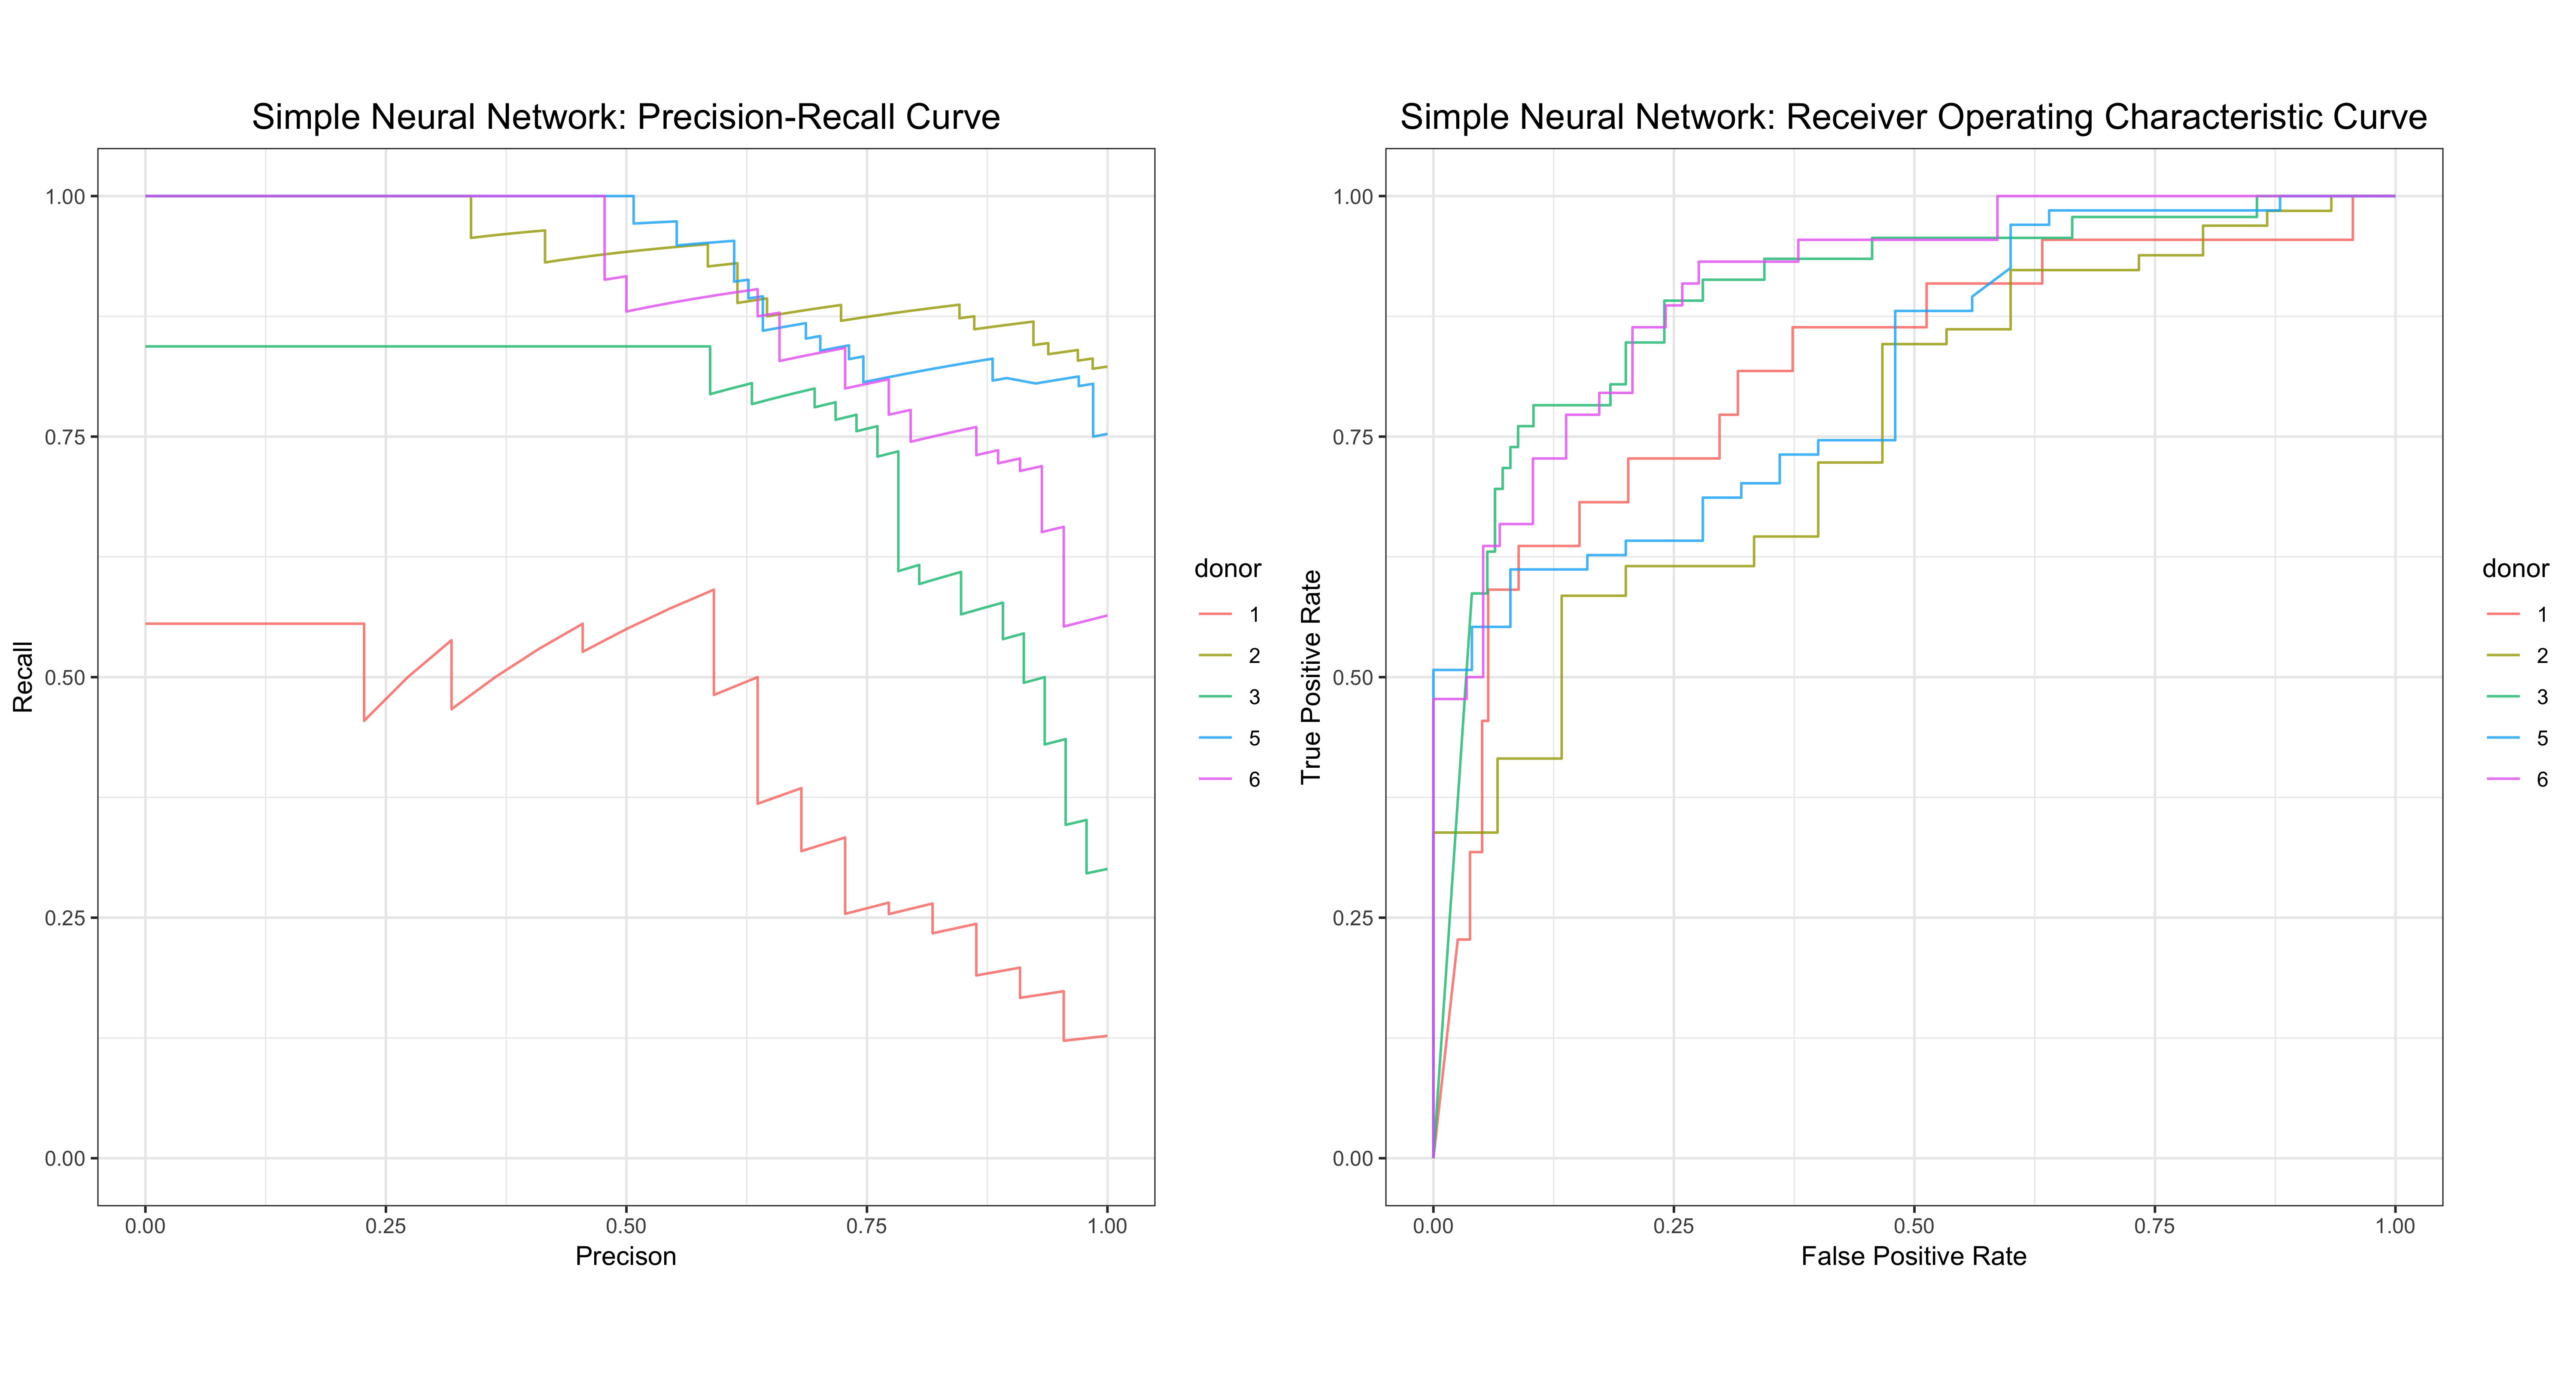

In [24]:
%%R -i pr_df,roc_df -w 15 -h 8 --units in -r 400

library("magrittr")
library("ggplot2")
library("ggpubr")

pr_df$donor = factor(pr_df$donor)
roc_df$donor = factor(roc_df$donor)

for (d in c(1, 2, 3, 5, 6)){
    inx = which(pr_df$donor == d)
    # Not plot the last arbitary precision (1, created by numpy)
    pr_df$precision[tail(inx, n=1)] = pr_df$precision[tail(inx, n=2)[1]]
}

# Draw the PR-curve
p1 = ggplot(pr_df, aes(x=recall, y=precision, group=donor, color=donor)) +
    geom_path(size=0.5, alpha=0.8) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5, size=15),
          legend.position = "right") +
    ylim(0, 1) +
    xlab("Precison") + ylab("Recall") +
    coord_fixed() +
    ggtitle("Simple Neural Network: Precision-Recall Curve")

# Draw the ROC-curve
p2 = ggplot(roc_df, aes(x=fpr, y=tpr, group=donor, color=donor)) +
    geom_path(size=0.5, alpha=0.8) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5, size=15),
          legend.position = "right") +
    ylim(0, 1) +
    xlab("False Positive Rate") + ylab("True Positive Rate") +
    coord_fixed() +
    ggtitle("Simple Neural Network: Receiver Operating Characteristic Curve")

ggarrange(p1, p2, ncol=2)

Based on the summary table and the PR-curve, simple neural network is struggling to predict images from Donor 1 and Donor 3. The reason might be these two donors contribute to the most images so the training/tuning set is smaller than other test donors.